In [34]:
%gui qt
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import cm
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

import sys
import scipy
import numpy as np
import math
import cmath

from scipy import stats
import scipy.stats as stats 
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

import scipy.signal
import string
import corner

import matplotlib as mpl
mpl.rcParams['text.usetex'] = False
mpl.rcParams['font.family'] = 'DejaVu Serif'  # or just 'DejaVu Sans' to match default


# Plot MCMC results

[[22.87792909  4.7760979  14.88566859]
 [77.77206976  5.36394481 14.14693532]
 [49.87694007  4.6821674  16.90834906]
 ...
 [28.83589512  4.6710772  24.9020818 ]
 [33.39487429  4.77863925 21.11610103]
 [30.76141167  4.735423   19.5612327 ]]


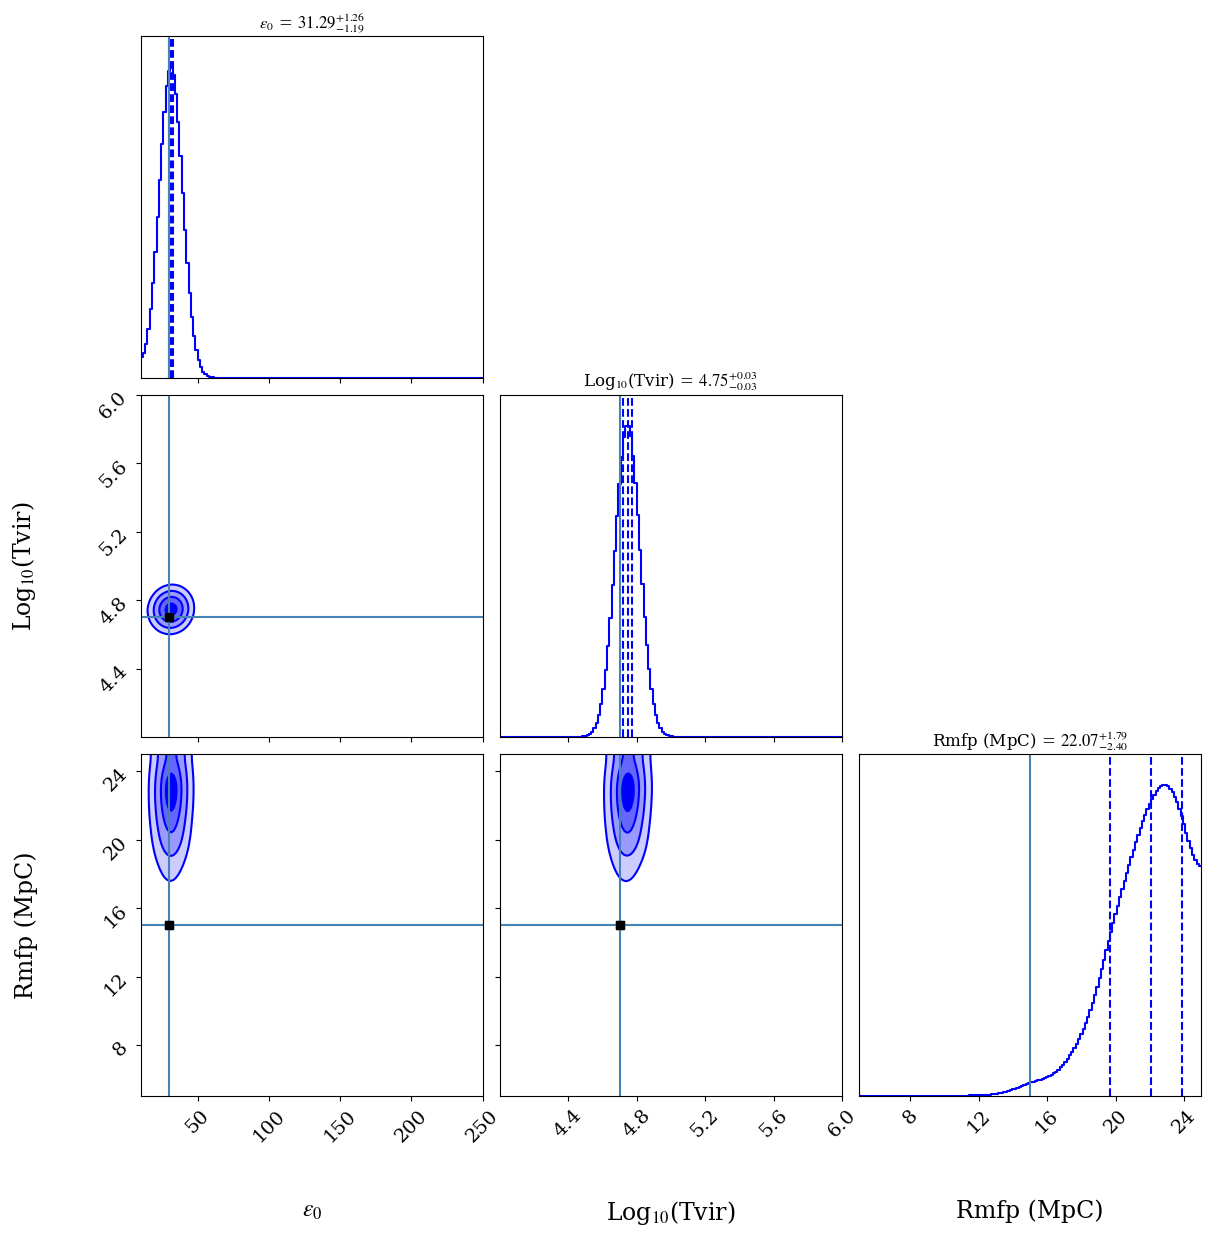

In [36]:
np.seterr(invalid='ignore', divide='ignore')
from decimal import *

FOURPLACES = Decimal(10) ** -4       # same as Decimal('0.0001')
SIXPLACES = Decimal(10) ** -6       # same as Decimal('0.0001')

#def main():
if __name__ == '__main__':

# Script to read in all the data and separate out the MCMC walkers into initial conditions, burn-in and actual data
# This script only reads all the data and all associated quantities together into memory.
# Can modify this script to do whatever you choose

#### NOTE ###
# This only works on the actual MCMC data (i.e. not the burn-in data).

# 1) Must manually provide the total number of redshifts used by 21CMMC.py (i.e. the sum total of Redshift and Redshifts_For_Prior if the co-eval option is set). 
#If the light-cone option is set, must provide the total number of redshifts (number of redshifts in the AveData_* textfile)

    n_redshifts = 3

# 2) Must manually provide the number of sample iterations and the walkers ratio chosen in 21CMMC.p5
    walkers_ratio =30
    
    sample_iterations = 2000

# 3) Provide the directory name for the stored data (21CMMC.py will create the directory with a timestamp)
    KeepDataString = '21CMMC/Results_all/'
    Stored_AveData = 'AveData'
    Stored_TauData = 'TauData'
    Stored_PSData = 'StatisticalData'

    # Provide the remaining string to fill the file name (it'll read in all data, burnin and the actual data)
    # Switch the file name to include the directory if that is preferred
    FileNames = '../Image_inference_paper/30_ps/hathor_ps_nouncer/ReionModel_Final_HII_PS_SKA_Co-eval_multiz'
    # First the burn-in. It'll need the burn-in data to determine the accepted/rejected points of the actual MCMC data (i.e not the burn-in data)

    f = open('%sburnin.out'%(FileNames),'r')
    parameters_burnin = [[float(v) for v in line.rstrip('\n').split('\t')] for line in f.readlines()]
    f.close()

    f2 = open('%sburninprob.out'%(FileNames),'r')
    probs_burnin = [float(v) for v in f2.readlines()]
    f2.close()

    f3 = open('%sNFvalsburnin.out'%(FileNames),'r')
    NFvals_Burnin = [[float(v) for v in line.rstrip('\n').split('\t')] for line in f3.readlines()]
    f3.close()


    # Now the MCMC data

    f = open('%s.out'%(FileNames),'r')
    parameters = [[float(v) for v in line.rstrip('\n').split('\t')] for line in f.readlines()]
    f.close()
    
    f2 = open('%sprob.out'%(FileNames),'r')
    probs = [float(v) for v in f2.readlines()]
    f2.close()

    f3 = open('%sNFvals.out'%(FileNames),'r')
    NFvals = [[float(v) for v in line.rstrip('\n').split('\t')] for line in f3.readlines()]
    f3.close()


    # Number of total iterations for the burn-in and main MCMC. Useful for lengths of lists/arrays
    nsamples_burnin = len(probs_burnin)
    nsamples = len(probs)
    sample_burnin = int(nsamples_burnin/walkers_ratio/3) # 3 parameters, change if you need
    sample_iterations = int(nsamples/walkers_ratio/3)
    # Total number of sampled astrophysical/cosmological parameters
    n_parameters = len(parameters[0])
    # Total number of iterations
    n_iterations = len(parameters)
    # Total number of walkers
    n_walkers = walkers_ratio*n_parameters
    reuse_burnin = True
        
    chain_wal = [[] for i in range(n_walkers)]
    nacc_wal = np.zeros(n_walkers)

    # Rudimentary check to determine if the inputs match the expected amount of data
    if walkers_ratio*n_parameters*sample_iterations != n_iterations:
        print('ERROR: The inputs (walkers_ratio, sample_iterations) have not been added correctly.\
              Make sure these numbers are correct')


    # Read in the file names of all the walker files. These aren't needed, but could come in use depending on the application
    path = '%s/WalkerData'%(KeepDataString)

   # WalkerFileNames = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f)) and 'Cosmology' not in f]
   # WalkerFileNames_Cosmology = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f)) and 'Cosmology' in f]


    # Set up a list to store True/False data which denotes whether the corresponding walker (sampled parameter set) was accepted/rejected
    LikelihoodCheck = []
    LikelihoodCheckBurnin = []


    burnin_iterations = len(parameters_burnin)/n_walkers

    # A counter, which will be used to store the total number of accepted positions
    total_true = 0

    # Now go through the entire main MCMC data and determine the positions accepted/rejected
    if reuse_burnin:
        for i in range(sample_burnin-1):
            for ii in range(n_walkers):

                if parameters_burnin[int(ii+i*n_walkers)] == parameters_burnin[int(ii+(i+1)*n_walkers)]:
                    LikelihoodCheckBurnin.append(False)
                    chain_wal[ii].append(parameters_burnin[int(ii+(i+1)*n_walkers)])

                    # New proposed position was rejected
                else:
                    LikelihoodCheckBurnin.append(True)
                    chain_wal[ii].append(parameters_burnin[int(ii+(i+1)*n_walkers)])
                    # New proposed position was accepted

                    total_true += 1
                    
    # This first loop checks whether the first positions in the main MCMC are new, relative to the final position of the burn-in data
    for ii in range(n_walkers):
        if parameters_burnin[int(ii+(burnin_iterations-1)*n_walkers)] == parameters[int(ii)] :# HI 30 or  ii == 55
        # New proposed position was rejected
            LikelihoodCheck.append(False)
            chain_wal[ii].append(parameters[ii])

        else:
        # New proposed position was accepted
            LikelihoodCheck.append(True)
            chain_wal[ii].append(parameters[ii])
            nacc_wal[ii]+=1

            total_true += 1

    for i in range(sample_iterations-1):
        for ii in range(n_walkers):

            if parameters[int(ii+i*n_walkers)] == parameters[int(ii+(i+1)*n_walkers)]:#or ii not in allid:# or ii not in allid:## HI 30 or  ii == 55  or ii not in allid
                LikelihoodCheck.append(False)
                chain_wal[ii].append(parameters[ii+(i+1)*n_walkers])

                # New proposed position was rejected
            else:
                
                LikelihoodCheck.append(True)
                total_true += 1
                nacc_wal[ii]+=1

                chain_wal[ii].append(parameters[int(ii+(i+1)*n_walkers)])
                separator = "_"

                # New proposed position was accepted


    All_fstar     = np.zeros(total_true)
    All_alphastar = np.zeros(total_true)
    All_fesc      = np.zeros(total_true)

   # AllData_zvals = np.loadtxt('%s/%s/AveData_%s.txt'%(KeepDataString,Stored_AveData,StringArgument), usecols=(0,))

    index_true = 0
    param_arr_bur = np.asarray(parameters_burnin)

    param_arr = np.asarray(parameters)
    prob_acc = []
    
    # This was for a specific test where we reused the burning iterations, but not needed in general 
    if reuse_burnin:
    
        for i in range(len(LikelihoodCheckBurnin)):
            if LikelihoodCheckBurnin[i] is True and probs_burnin[i] < 70:

                All_fstar[index_true] =  param_arr_bur[i][0]
                All_alphastar[index_true] = param_arr_bur[i][1] #np.loadtxt('%s/WalkerData/Walker_%s.txt'%(KeepDataString,StringArgument), usecols=(1,))[8]
                All_fesc[index_true] = param_arr_bur[i][2]#np.loadtxt('%s/WalkerData/Walker_%s.txt'%(KeepDataString,StringArgument), usecols=(1,))[9]
                index_true += 1
                prob_acc.append(probs_burnin[i])
    
    for i in range(nsamples):
        if LikelihoodCheck[i] is True :
            seq = []
            # Add the random thread ID
            #seq.append("%s"%(Decimal(repr(NFvals[i][n_redshifts])).quantize(SIXPLACES)))
            # Add the second ID
           # seq.append("%s"%(Decimal(repr(NFvals[i][n_redshifts+1])).quantize(SIXPLACES)))

            #StringArgument = string.join(seq,separator)
            #print StringArgument
           # print param_arr[i][0]
            All_fstar[index_true] =  param_arr[i][0]
            All_alphastar[index_true] = param_arr[i][1] #np.loadtxt('%s/WalkerData/Walker_%s.txt'%(KeepDataString,StringArgument), usecols=(1,))[8]
            All_fesc[index_true] = param_arr[i][2]#np.loadtxt('%s/WalkerData/Walker_%s.txt'%(KeepDataString,StringArgument), usecols=(1,))[9]
            prob_acc.append(probs[i])
            index_true += 1

#print index_true


#it's always easier to save the good list of paramteers so you don't have to re-do the steps above each time.
# Then you can just look at the results using the cell below
#np.savetxt('21CMMC/Results_all/chains_200_hii_all2.txt', D, fmt='%f %f %f')



### PLOTTING THE RESULTS ######


names = [r'$\epsilon_0$', 'Log$_{10}$(Tvir)','Rmfp (MpC)']
value1 = np.array([30.,4.7,15])
#value1 = np.array([200.,5.48,15])
#value2 = np.median(D, axis=0)
paramRanges = ((10,250),
               (4,6),
               (5,25))
released = {
   # "linewidths" : (1,2),
    "colors" : ('b','b'),
    }

D = np.vstack((All_fstar[:], All_fesc[:], All_alphastar[:])).T

fig =corner.corner(D, bins= 150, show_titles=True,\
                   labels = names,truths=value1,range = paramRanges,color='blue', hist_bin_factor=1,\
                   smooth=5., smooth1d=5.,contour_kwargs=released, quantiles=[0.16, 0.5, 0.84],fill_contours=True,
                    plot_datapoints=False)


fig.set_size_inches(13, 13)
axes = np.array(fig.axes).reshape((3, 3))

ndim = 3 
for i in range(ndim):
    ax = axes[i, i]
   # ax.axvline(value1[i],color="k", linestyle = '--')
   # if (i == 1):
   #     ax.set_ylim((0,0.08))
    if (i == 2):
        ax.set_xlabel(names[i], fontsize = 17)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 14)        

for yi in range(ndim):
    for xi in range(yi):
        ax = axes[yi, xi]
        
       # ax.axvline(value1[xi], color="k", linestyle = '--')
       # ax.axhline(value1[yi], color="k", linestyle = '--')
        ax.plot(value1[xi], value1[yi], "sk")
        
        if(xi == 0):
            ax.set_ylabel(names[yi], fontsize= 17)
        ax.set_xlabel(names[xi], fontsize = 17)
        ax.tick_params(axis = 'both', which = 'major', labelsize = 14)        




## Check chains convergence

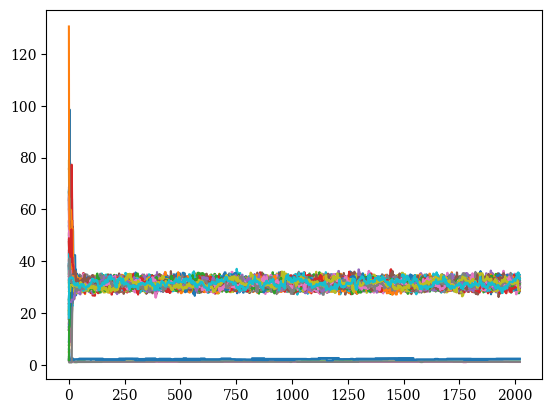

In [37]:
# print(np.asarray(chain_wal)[:5])

for i in range(90):
    plt.plot(np.asarray(chain_wal)[i,:,0])

plt.ylabel()
plt.xlabel()

## Checking separate

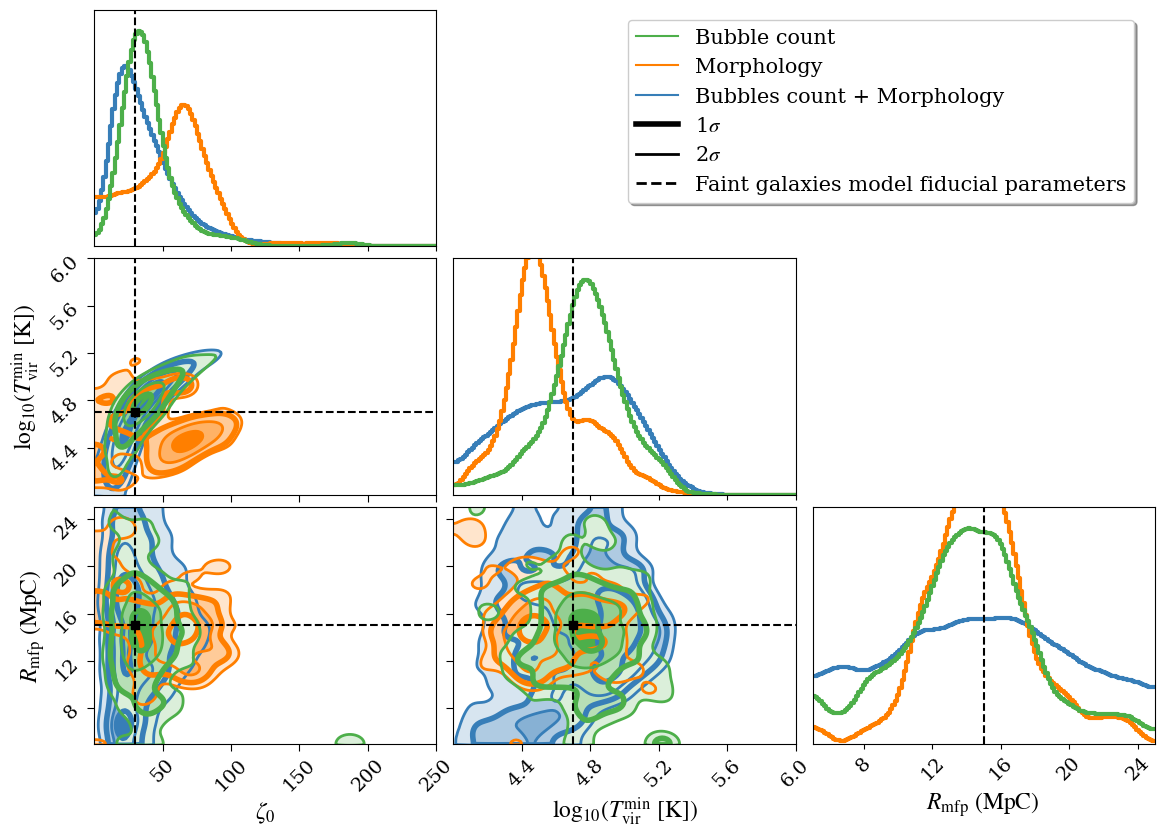

In [56]:
# For when you saved the main important parameters in txt files (see cell above), you can use 
# something like this to compare several runs 
colors = ['#377eb8', '#ff7f00', '#4daf4a', '#bc4ce9']
xlan = [r'$\epsilon_0$', 'Log10(Tvir)']
ylan = ['Log10(Tvir)','Rmfp (MpC)']
names = [r'$\zeta_0$', r'${\rm log}_{10}(T^{\rm min}_{\rm vir}\ [{\rm K}])$',r'$R_{\rm mfp}\ {\rm (MpC)}$ ']
value1 = np.array([30.,4.7,15])
# value1 = np.array([200.,5.48,15])

paramRanges = ((0,250),
               (4,6),
               (5,25))


D2 = np.loadtxt('../Results_inference/30_hii_all/chains_30_hii_all_newbox.txt')
D3 = np.loadtxt('../Results_inference/30_hii_morph/zeus_morphoonly_maha5/chains_morpho_only.txt')
D4 = np.loadtxt('../Results_inference/30_hii_bub/chains_30_hii_bub_run2.txt')
D = np.concatenate((D2,D3,D4))

smoval = 5
smoval1d = 5.


released = {
    "linewidths" : (2,4),
    "colors" : (colors[0],colors[0]),
 #   "alpha" : 0.1
    }
fig = corner.corner(D4,  bins= 150, show_titles=False,\
                   range = paramRanges,color=colors[0], hist_bin_factor=1, smooth=smoval,\
                   smooth1d=smoval1d,fill_contours=True,contour_kwargs=released,label_kwargs={"fontsize":16},\
                   weights=np.ones(len(D4))/len(D4), plot_datapoints=False, plot_density = False,\
                   hist_kwargs = {"linewidth" : 3.})

released = {
   "linewidths" : (2,4),
    "colors" : (colors[1],colors[1]),
   # "alpha" : 0.1
    }
corner.corner(D3,fig=fig,  bins= 150, show_titles=False,\
                   range = paramRanges,color=colors[1], hist_bin_factor=1, smooth=smoval,\
                   smooth1d=smoval1d,fill_contours=True,contour_kwargs=released,label_kwargs={"fontsize":16},\
                   weights=np.ones(len(D3))/len(D3),plot_datapoints=False, plot_density = False,\
             hist_kwargs = {"linewidth" : 3.})


released = {
    "linewidths" : (2,4),
    "colors" : (colors[2],colors[2]),
   #     "alpha" : 0.1
    }
corner.corner(D2, fig=fig, bins= 150,  show_titles=False,\
                   range = paramRanges,color=colors[2], hist_bin_factor=1, smooth=smoval,\
                   smooth1d=smoval1d,fill_contours=True,contour_kwargs=released,label_kwargs={"fontsize":16},\
                   weights=np.ones(len(D2))/len(D2), plot_datapoints=False, plot_density = False,\
             hist_kwargs = {"linewidth" : 3.})


# # released = {np.ones(len(samples2))*len(samples1)/len(samples2))


# released = {
#     "linewidths" : (2,4),
#     "colors" : (colors[3],colors[3]),
#    #     "alpha" : 0.1
#     }
# corner.corner(D4, fig=fig,bins= 150, show_titles=False,\
#                 range = paramRanges,color=colors[3], hist_bin_factor=1, \
#                 smooth=smoval, smooth1d=smoval1d,contour_kwargs=released, fill_contours=False, \
#               plot_datapoints=False,label_kwargs={"fontsize":16},\
#                    weights=np.ones(len(D4))/len(D4), plot_density = False,\
#              hist_kwargs = {"linewidth" : 3.})





fig.set_size_inches(13, 9)
axes = np.array(fig.axes).reshape((3, 3))
#value1 = np.array([30.,4.7,15])
ndim = 3

line3 = mlines.Line2D([], [], color=colors[0], label='Bubbles count + Morphology')
line2 = mlines.Line2D([], [], color=colors[1], label='Morphology')
line1 = mlines.Line2D([], [], color=colors[2], label='Bubble count')
#line4 = mlines.Line2D([], [], color=colors[3], label='Power Spectrum')
line5 = mlines.Line2D([], [], color='k', linewidth = 4,  label=r'1$\sigma$')
line6 = mlines.Line2D([], [], color='k', linewidth = 2, label=r'2$\sigma$')
line7 = mlines.Line2D([], [], color='k', linewidth = 2, linestyle = '--' ,label='Faint galaxies model fiducial parameters')

#plt.legend( bbox_to_anchor=(0., 1.0, 1., .0), loc=4)
l=plt.legend(handles=[line1,line2,line3,line5,line6, line7], loc='upper center', bbox_to_anchor=(0.2, 3.1),
           ncol=1, fancybox=True, shadow=True, fontsize = 15) #, title = r'x$_{\rm H II}$ = 0.2'

for i in range(ndim):
    ax = axes[i, i]
    ax.axvline(value1[i],color="k", linestyle = '--')
    if (i == 2):
        ax.set_xlabel(names[i], fontsize = 17)
       # plt.ylim((0,0.0))
    ax.tick_params(axis = 'both', which = 'major', labelsize = 14)        

for yi in range(ndim):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.axvline(value1[xi], color="k", linestyle = '--')
        ax.axhline(value1[yi], color="k", linestyle = '--')
        ax.plot(value1[xi], value1[yi], "sk")
        
        if(xi == 0):
            ax.set_ylabel(names[yi], fontsize= 17)
        ax.set_xlabel(names[xi], fontsize = 17)
        ax.tick_params(axis = 'both', which = 'major', labelsize = 14, length = 5)        

#plt.plot(np.histogram2d(All_fstar, All_fesc)[1],np.histogram2d(All_fstar, All_fesc)[0] )
#H, xedges, yedges = np.histogram2d(All_fstar, All_fesc, bins=(xedges, yedges))

#plt.savefig('30_hii_newbox.pdf', bbox_inches='tight')

